In [1]:
from datasets.display import show_detections
import datasets.pascal_voc as pascal
import matplotlib.pyplot as plt
from matplotlib import patches
from model import build_network
import numpy as np
import skimage
from skimage import io, transform
import tensorflow as tf

c:\users\smmeenehan\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Check basic functionality in eager mode

In [3]:
tf.enable_eager_execution()

In [2]:
image_paths, annotation_paths = pascal.get_image_paths()

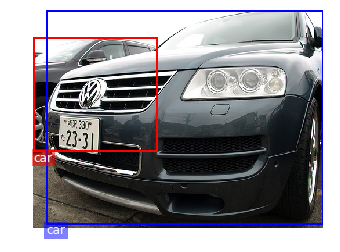

In [5]:
rand_idx = np.random.randint(0, len(image_paths))
image, class_ids, bboxes = pascal.load_image_data(image_paths[rand_idx], annotation_paths[rand_idx])
show_detections(image, bboxes, class_ids, pascal.PASCAL_CLASSES)

In [7]:
image_tens = tf.convert_to_tensor(image[None, :])
id_tens = tf.convert_to_tensor(class_ids[None, :])
box_tens = tf.convert_to_tensor(bboxes[None, :])
outputs = build_network(image_tens, id_tens, box_tens, {}, True, True)

In [10]:
roi_targets, roi_logits, roi_deltas = outputs['roi']
roi_target_classes, roi_target_deltas = outputs['roi_targets']

# Check estimator training

In [3]:
num_images = 100
max_num_obj = 0
all_images, all_ids, all_bboxes = [], [], []
for idx in range(num_images):
    this_image, this_ids, this_boxes = pascal.load_image_data(image_paths[idx], annotation_paths[idx])
    if this_image.shape != (375, 500, 3):
        continue
    all_images.append(this_image)
    all_ids.append(this_ids)
    all_bboxes.append(this_boxes)
    if this_ids.size>max_num_obj:
        max_num_obj = this_ids.size
        
all_ids = [np.pad(x, ((0, max_num_obj-x.size)), 'constant', constant_values=-1) for x in all_ids]
all_bboxes = [np.pad(x, ((0, max_num_obj-x.shape[0]), (0, 0)), 'constant') for x in all_bboxes]

images = np.stack(all_images, axis=0)
class_ids = np.stack(all_ids, axis=0)
bboxes = np.stack(all_bboxes, axis=0)

In [4]:
images = images-np.mean(images,axis=0)

In [5]:
from model import model_fn
estimator = tf.estimator.Estimator(model_fn, model_dir='logs/test_FRCNN', params={}, 
                                   config=tf.estimator.RunConfig(keep_checkpoint_max=1))

INFO:tensorflow:Using config: {'_model_dir': 'logs/test_FRCNN', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 1, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000000010D6FAC8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [6]:
input_fn = tf.estimator.inputs.numpy_input_fn(images, y={'classes': class_ids, 'bboxes': bboxes}, shuffle=True, batch_size=1)

In [7]:
estimator.train(input_fn)

INFO:tensorflow:Calling model_fn.


c:\users\smmeenehan\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


InvalidArgumentError: Received a label value of 10 which is outside the valid range of [0, 2).  Label values: 10 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
	 [[Node: rpn_loss/sparse_softmax_cross_entropy_loss/xentropy/xentropy = SparseSoftmaxCrossEntropyWithLogits[T=DT_FLOAT, Tlabels=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](rpn_loss/GatherNd, rpn_loss/GatherNd_1)]]

Caused by op 'rpn_loss/sparse_softmax_cross_entropy_loss/xentropy/xentropy', defined at:
  File "c:\users\smmeenehan\appdata\local\programs\python\python36\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\smmeenehan\appdata\local\programs\python\python36\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\smmeenehan\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\users\smmeenehan\appdata\local\programs\python\python36\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "c:\users\smmeenehan\appdata\local\programs\python\python36\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "c:\users\smmeenehan\appdata\local\programs\python\python36\lib\site-packages\tornado\platform\asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "c:\users\smmeenehan\appdata\local\programs\python\python36\lib\asyncio\base_events.py", line 422, in run_forever
    self._run_once()
  File "c:\users\smmeenehan\appdata\local\programs\python\python36\lib\asyncio\base_events.py", line 1432, in _run_once
    handle._run()
  File "c:\users\smmeenehan\appdata\local\programs\python\python36\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "c:\users\smmeenehan\appdata\local\programs\python\python36\lib\site-packages\tornado\ioloop.py", line 759, in _run_callback
    ret = callback()
  File "c:\users\smmeenehan\appdata\local\programs\python\python36\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\smmeenehan\appdata\local\programs\python\python36\lib\site-packages\zmq\eventloop\zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "c:\users\smmeenehan\appdata\local\programs\python\python36\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "c:\users\smmeenehan\appdata\local\programs\python\python36\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "c:\users\smmeenehan\appdata\local\programs\python\python36\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "c:\users\smmeenehan\appdata\local\programs\python\python36\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\smmeenehan\appdata\local\programs\python\python36\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "c:\users\smmeenehan\appdata\local\programs\python\python36\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "c:\users\smmeenehan\appdata\local\programs\python\python36\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "c:\users\smmeenehan\appdata\local\programs\python\python36\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\users\smmeenehan\appdata\local\programs\python\python36\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\users\smmeenehan\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "c:\users\smmeenehan\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\users\smmeenehan\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py", line 2909, in run_ast_nodes
    if self.run_code(code, result):
  File "c:\users\smmeenehan\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-2db5933006ee>", line 1, in <module>
    estimator.train(input_fn)
  File "c:\users\smmeenehan\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\estimator\estimator.py", line 363, in train
    loss = self._train_model(input_fn, hooks, saving_listeners)
  File "c:\users\smmeenehan\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\estimator\estimator.py", line 843, in _train_model
    return self._train_model_default(input_fn, hooks, saving_listeners)
  File "c:\users\smmeenehan\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\estimator\estimator.py", line 856, in _train_model_default
    features, labels, model_fn_lib.ModeKeys.TRAIN, self.config)
  File "c:\users\smmeenehan\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\estimator\estimator.py", line 831, in _call_model_fn
    model_fn_results = self._model_fn(features=features, **kwargs)
  File "C:\Users\smmeenehan\Documents\TensorFlowProjects\Faster R-CNN\model.py", line 46, in model_fn
    loss = setup_loss(outputs)
  File "C:\Users\smmeenehan\Documents\TensorFlowProjects\Faster R-CNN\model.py", line 159, in setup_loss
    rpn_class_loss = class_loss(rpn_logits, rpn_target_classes)
  File "C:\Users\smmeenehan\Documents\TensorFlowProjects\Faster R-CNN\network\losses.py", line 56, in class_loss
    logits=relevant_logits)
  File "c:\users\smmeenehan\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\losses\losses_impl.py", line 853, in sparse_softmax_cross_entropy
    name="xentropy")
  File "c:\users\smmeenehan\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 2050, in sparse_softmax_cross_entropy_with_logits
    precise_logits, labels, name=name)
  File "c:\users\smmeenehan\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 8018, in sparse_softmax_cross_entropy_with_logits
    labels=labels, name=name)
  File "c:\users\smmeenehan\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "c:\users\smmeenehan\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\ops.py", line 3392, in create_op
    op_def=op_def)
  File "c:\users\smmeenehan\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Received a label value of 10 which is outside the valid range of [0, 2).  Label values: 10 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
	 [[Node: rpn_loss/sparse_softmax_cross_entropy_loss/xentropy/xentropy = SparseSoftmaxCrossEntropyWithLogits[T=DT_FLOAT, Tlabels=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](rpn_loss/GatherNd, rpn_loss/GatherNd_1)]]
